In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
from scipy.io import wavfile
import librosa
import librosa.display
import matplotlib.pyplot as plt
import json

import numpy as np
import skimage.io
import cv2

from google.colab.patches import cv2_imshow


In [23]:
x , sr = librosa.load('./drive/MyDrive/COUGHVID/testcough.webm')
#x_prime, sr_prime = librosa.load('./testcough.webm')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [24]:
print(type(x))

<class 'numpy.ndarray'>


In [25]:
print(x)

[0. 0. 0. ... 0. 0. 0.]


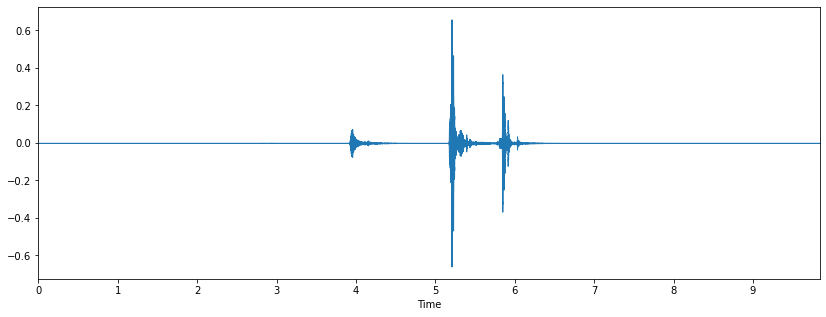

In [26]:
plt.figure(figsize=(14,5))
librosa.display.waveplot(x)


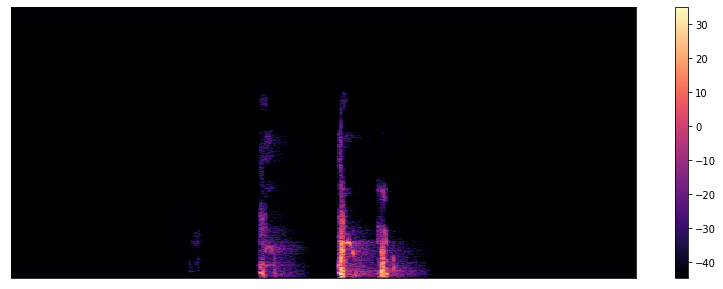

In [27]:
x_new = librosa.stft(x)
x_db = librosa.amplitude_to_db(abs(x_new))

plt.figure(figsize=(14,5))
librosa.display.specshow(x_db, sr=sr)
plt.colorbar()

Example how to load one of the JSON description files:

In [28]:
with open('./drive/MyDrive/COUGHVID/testcough.json') as json_file:
  data = json.load(json_file)
  
print(data)

{'datetime': '2020-09-08T17:34:16.064530+00:00', 'cough_detected': '0.3794'}


We can extract this and the loading of the sound files into functions so we can reuse them:

In [29]:
def load_json_from_drive(filename):
  with open('./drive/MyDrive/COUGHVID/' + filename) as json_file:
    data = json.load(json_file)
  
  return data

def load_soundfile_from_drive(filename):
  x , sr = librosa.load('./drive/MyDrive/COUGHVID/' + filename)
  return x, sr

print(load_json_from_drive('testcough.json'))
print(load_soundfile_from_drive('testcough.webm'))

{'datetime': '2020-09-08T17:34:16.064530+00:00', 'cough_detected': '0.3794'}


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 22050)


Furthermore we can list all the files in the drive folder by:

In [30]:
!ls './drive/MyDrive/COUGHVID'

00a0156b-7179-4773-8a2c-4bb919e076bd.json
00a0156b-7179-4773-8a2c-4bb919e076bd.ogg
00a2faca-e1f2-4848-9afe-058f949d3252.json
00a2faca-e1f2-4848-9afe-058f949d3252.webm
00a4e142-2ae1-401e-8319-837e512b1281.json
00a4e142-2ae1-401e-8319-837e512b1281.webm
00b2a7e8-60ce-488d-9fcf-6b5946d4bbc9.json
00b2a7e8-60ce-488d-9fcf-6b5946d4bbc9.webm
00bf9f83-2e8f-47cf-a4f2-97f2beceebc1.json
00bf9f83-2e8f-47cf-a4f2-97f2beceebc1.webm
00ca82a7-88b5-4441-b941-4bfa9bfb3b34.json
00ca82a7-88b5-4441-b941-4bfa9bfb3b34.webm
00cab9a7-6d1b-44ac-b2b0-3beefebee783.json
00cab9a7-6d1b-44ac-b2b0-3beefebee783.webm
00ccf4e3-6e4f-4e6b-a16d-11b4a8999d1e.json
00ccf4e3-6e4f-4e6b-a16d-11b4a8999d1e.webm
00ce5b06-c302-4387-bbd7-86355a4a8c12.json
00ce5b06-c302-4387-bbd7-86355a4a8c12.webm
00ce9f7f-e738-474b-a7fc-ab4d3cf323df.json
00ce9f7f-e738-474b-a7fc-ab4d3cf323df.webm
00ddf050-6939-4f33-9e54-fcb309b895ec.json
00ddf050-6939-4f33-9e54-fcb309b895ec.webm
00e0a33c-6561-406e-b543-4c9f07b860f7.json
00e0a33c-6561-406e-b543-4c9f07b860f

We can now load all the json files in a loop:

In [31]:
tmp = !ls './drive/MyDrive/COUGHVID'

files = np.array(tmp)

json_data = []

for filename in files:
  substring = '.json'
  if substring in filename:
    new_data = load_json_from_drive(filename)
    json_data.append(new_data)
    
print(json_data)

[{'datetime': '2020-04-12T19:49:03.304079+00:00', 'cough_detected': '0.3747', 'latitude': '36.5', 'longitude': '-6.3', 'age': '52', 'gender': 'male', 'respiratory_condition': 'False', 'fever_muscle_pain': 'False', 'status': 'healthy'}, {'datetime': '2020-04-17T15:11:54.078927+00:00', 'cough_detected': '0.9941', 'latitude': '42.3', 'longitude': '-3.7'}, {'datetime': '2020-04-09T21:01:33.218335+00:00', 'cough_detected': '0.9926', 'latitude': '46.3', 'longitude': '6.4'}, {'datetime': '2020-04-18T19:32:54.707684+00:00', 'cough_detected': '0.9504', 'latitude': '46.2', 'longitude': '7.4'}, {'datetime': '2020-04-13T19:08:23.388936+00:00', 'cough_detected': '0.9815', 'latitude': '41.1', 'longitude': '29.0', 'age': '37', 'gender': 'male', 'respiratory_condition': 'True', 'fever_muscle_pain': 'False', 'status': 'healthy', 'expert_labels_3': {'quality': 'good', 'cough_type': 'wet', 'dyspnea': 'False', 'wheezing': 'False', 'stridor': 'False', 'choking': 'False', 'congestion': 'False', 'nothing': '

And we can further load all the sound files in a loop:

In [32]:
tmp = !ls './drive/MyDrive/COUGHVID'

files = np.array(tmp)

sound_data = []

for filename in files:
  substring_one = '.webm'
  substring_two = '.ogg'
  if substring_one in filename or substring_two in filename:
    new_data = np.array(load_soundfile_from_drive(filename))
    sound_data.append(new_data)

print(sound_data)


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) 

[array([array([ 0.        ,  0.        ,  0.        , ..., -0.00021387,
       -0.00054463,  0.        ], dtype=float32),
       22050], dtype=object), array([array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 22050],
      dtype=object), array([array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -3.1163527e-05, -7.5953260e-08, -5.3812915e-08], dtype=float32),
       22050], dtype=object), array([array([ 0.        ,  0.        ,  0.        , ..., -0.07184508,
       -0.0524673 , -0.01215994], dtype=float32),
       22050], dtype=object), array([array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 22050],
      dtype=object), array([array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -6.4057967e-05, -4.1196454e-05,  1.7393368e-05], dtype=float32),
       22050], dtype=object), array([array([0.        , 0.        , 0.        , ..., 0.02777408, 0.02185175,
       0.02098412], dtype=float32),
       22050], dtype=object), array([array([0.        , 0.        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Now lets try segmentation of the coughs to get more comparable results. To do this, we can use the segmentation code provided in https://c4science.ch/diffusion/10770/

In [33]:
#Use old segmentation
def segment_cough(x,fs, cough_padding=0.2,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    """Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    
    Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""
                
    cough_mask = np.array([False]*len(x))
    

    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

def compute_SNR(x, fs):
    """Compute the Signal-to-Noise ratio of the audio signal x (np.array) with sampling frequency fs (float)"""
    segments, cough_mask = segment_cough(x,fs)
    RMS_signal = 0 if len(x[cough_mask])==0 else np.sqrt(np.mean(np.square(x[cough_mask])))
    RMS_noise = np.sqrt(np.mean(np.square(x[~cough_mask])))
    SNR = 0 if (RMS_signal==0 or np.isnan(RMS_noise)) else 20*np.log10(RMS_signal/RMS_noise)
    return SNR

In [34]:
x, sr = load_soundfile_from_drive('testcough.webm')

cough_segments, cough_mask = segment_cough(x, sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


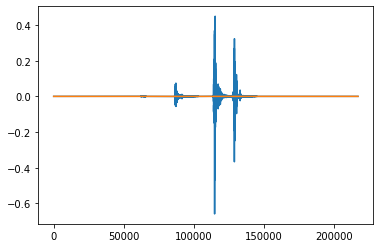

In [35]:
plt.plot(x)
plt.plot(cough_mask)

In [36]:
print(load_json_from_drive('testcough.json'))

{'datetime': '2020-09-08T17:34:16.064530+00:00', 'cough_detected': '0.3794'}


The paper that we trying to reproduce feeds the so called Mel-Frequency Cepstral Coefficients(MFCC) into their neural network. These allow to feed the samples with different lenghts and therefor different dimensions into a neural network. The following cell shows how to generate MFCC from the cough recordings.


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


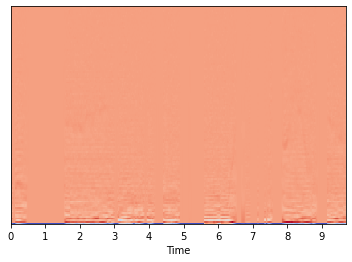

In [37]:
x_for_mfcc, sr = load_soundfile_from_drive('0a24fc10-114f-4741-9d4d-516848db8edf.webm')
#plt.plot(x_for_mfcc)

mfccs = librosa.feature.mfcc(x_for_mfcc, sr=sr, n_mfcc=128)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

# or we can go like this directly

S = librosa.feature.melspectrogram(y=x_for_mfcc, sr=sr, n_mels=128,fmax=8000)

In [38]:
#print(mfccs.shape)
#print(S.shape)
print(mfccs)

[[-6.20058289e+02 -6.02735474e+02 -5.59932190e+02 ... -3.75837769e+02
  -3.62801697e+02 -3.29236267e+02]
 [ 0.00000000e+00  3.58190489e+00  1.31704559e+01 ...  1.32301727e+02
   1.10620926e+02  9.45983429e+01]
 [ 0.00000000e+00  1.72089231e+00  9.05470085e+00 ... -3.60102768e+01
  -2.83387337e+01 -2.21148472e+01]
 ...
 [ 0.00000000e+00 -1.16165113e+00  7.95522690e-01 ...  5.09729385e-01
   6.06025696e-01  1.37398529e+00]
 [ 0.00000000e+00  6.78177714e-01 -2.40498543e-01 ... -1.81600571e-01
  -5.16356468e-01  3.74122620e-01]
 [ 0.00000000e+00 -8.51785302e-01 -6.44974232e-01 ...  5.69152832e-03
   6.81907654e-01  1.45457458e+00]]


The shape of the mfccs tells us how many mfccs are calculated on how many frames. The first value represents the number of mfccs calculated and the second value represents the number of frames available

In [40]:
skimage.io.imsave('test.png', S)

In [53]:
def resample_image(filname):

  img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)

  dim = (240,320)
  resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

  return resized


In [54]:
sample_filenames = ['0a6ddce4-896c-42be-b2dd-c70d315f9fd5.webm','0a6fe71c-7a8a-40c5-bb47-9baf9ddaaa5c.webm','0a07b7ef-ec8b-47a8-afb9-cc6ebeeb6505.webm','0a8e4279-3840-4872-9db8-3b5d8c53cc43.webm','0a8f3306-fd12-4689-b346-91fb29f9ae88.webm','0a20c162-bf07-4f79-9d5d-5e6101ae20ab.webm','0a24fc10-114f-4741-9d4d-516848db8edf.webm','0a33e5bd-366f-4fe2-8e44-c78ab352f592.webm','0a47e9a8-6b7f-4138-ba12-00f3bd1a8158.webm','00fdaa7b-d050-43b0-b606-155be40ac80f.webm']
counter = 1
for filename in sample_filenames:
  x, sr = load_soundfile_from_drive(filename)
  specto = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000)
  new_filename = 'testpicture_' + str(counter) + '.png'
  cv2.imwrite(new_filename, specto)
  counter += 1




/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [59]:
resized_images = []
for i in range(1,11):
  filename = 'testpicture_' + str(i) + '.png'
  resized_image = resample_image(filename)
  resized_images.append(resized_image)

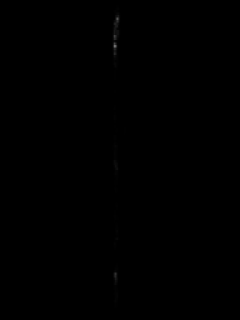

(320, 240, 1)


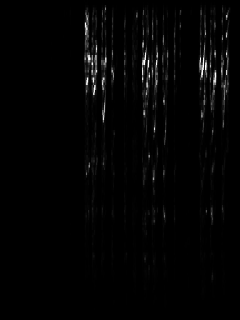

(320, 240, 1)


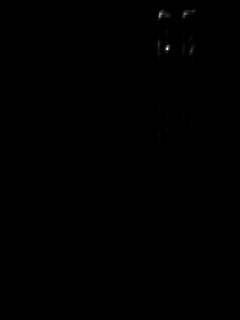

(320, 240, 1)


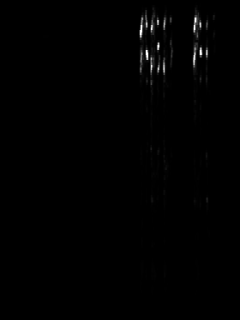

(320, 240, 1)


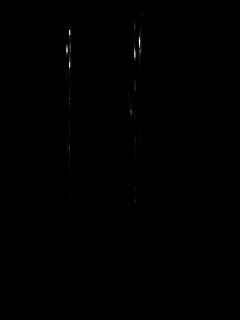

(320, 240, 1)


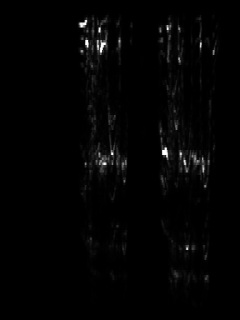

(320, 240, 1)


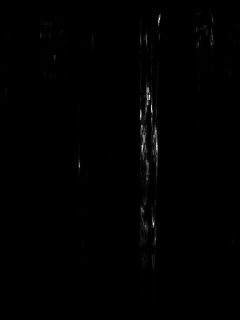

(320, 240, 1)


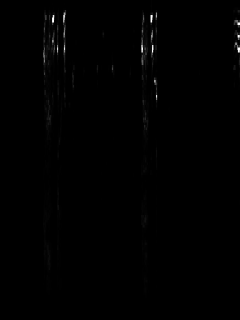

(320, 240, 1)


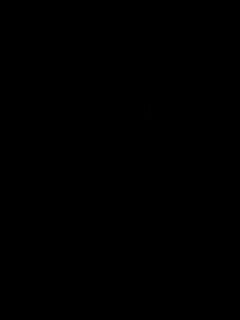

(320, 240, 1)


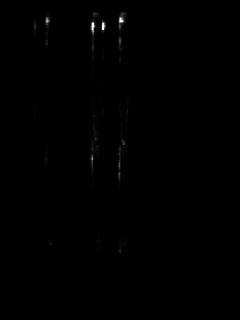

(320, 240, 1)


In [74]:
for image in resized_images:
  image.resize((320,240,1))
  cv2_imshow(image)
  print(image.shape)